<a href="https://colab.research.google.com/github/diego200052/Aprendizaje-Profundo-Tarea01-MMDR/blob/master/Ejercicio%204%20MMDR.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Red completamente conectada con PyTorch
## Clasificación de Fashion-MNIST con un red densa

Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre
el conjunto de Fashion-MNIST, tomando en cuenta las siguiente especificaciones:

- Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.
- Discute tus resultados con las distintas configuraciones.

## 1 Preparación

### 1.1 Bibliotecas

In [ ]:
# Biblioteca para inspeccionar arquitecturas
!pip install torchinfo
# Funciones aleatorias
import random
# Tomar n elementos de una secuencia
from itertools import islice as take

# Gráficas
import matplotlib.pyplot as plt
# Arreglos multidimensionales
import numpy as np
# Redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# Procesamiento de imágenes
from skimage import io
# Redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
# Inspección de arquitectura
from torchinfo import summary
# Barras de progreso
from tqdm.auto import trange

### 1.2 Auxiliares

In [ ]:
# Carpeta donde se almacenarán los datos
DATA_DIR = '../data'

# Tamaño del lote
BATCH_SIZE = 32
# Filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # Denormalizamos [0, 1] => [0, 255]
    x *= 255
    # Rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # Convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # Aplanamos canal
    x = x.reshape(*x.shape[:3])
    # Desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# Por reproducibilidad
set_seed()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/f79e17e7aaf27b8c2cbae98c947a33b347ff0e8a/figs/mnist_tuberia.svg" width="1050"/>
&nbsp;
Tuberia de datos para MNIST.

### 2.2 Exploración

PyTorch provee la clase [`MNIST`](https://pytorch.org/vision/0.8/datasets.html#mnist), una implementación de `Dataset` lista para usar del conjunto MNIST.

In [ ]:
# Se crea un Dataset con los datos de Fashion-MNIST
ds = FashionMNIST(
    # Carpeta donde están los datos
    root=DATA_DIR,
    # Subconjunto de entrenamiento
    train=True,
    # Convertir la imagen a ndarray
    transform=np.array,
    # Descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


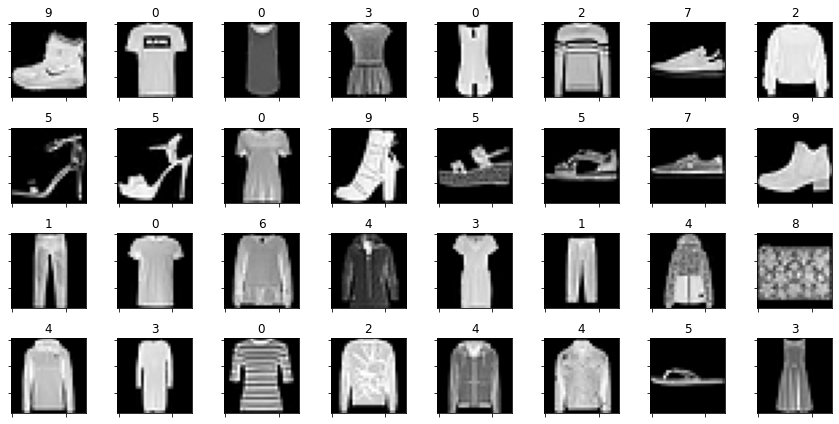

In [ ]:
# Cargar algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# Desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

### 2.3 Cargadores de datos

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/eval_trn_tst.svg" width="470"/>

&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


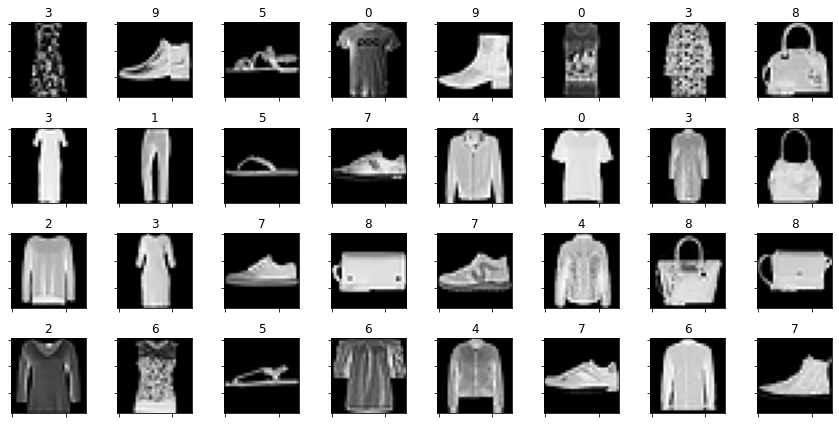

In [ ]:
# Transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# Crear un Dataset de Fashion-MNIST para entrenar
trn_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# Se crea un DataLoader con los datos de entrenamiento
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# Se depliega un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


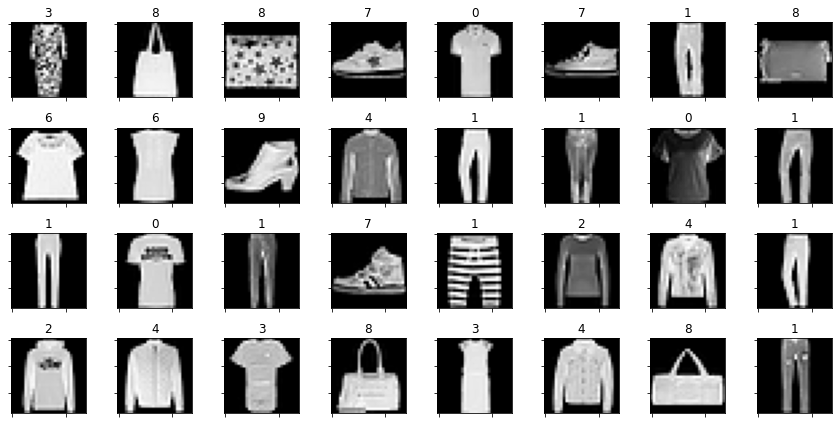

In [ ]:
# Crear un Dataset de Fasion-MNIST para validación
tst_ds = FashionMNIST(
    # Carpeta donde se están los datos
    root=DATA_DIR, 
    # Subconjunto de validación
    train=False,
    # Transformación
    transform=tsfm
)

# Se crea un DataLoader del conjunto de validación
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# Se despliega un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## 3 Modelo

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/fc_arch.svg" width="800"/>
&nbsp;
Arquitectura de la red completamente conectada.

### 3.1 Definición de la arquitectura

In [ ]:
# Definición del modelo
class FCN(nn.Module):

    # Inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # Se aplana la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

### 3.2 Instancia de la arquitectura

In [ ]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# Inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 28, 28]) => torch.Size([1, 10])


### 3.3 Inspección de la arquitectura

In [ ]:
summary(model, (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN                                      [1, 28, 28]               [1, 10]
├─Sequential: 1-1                        [1, 28, 28]               [1, 10]
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─ReLU: 2-3                         [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 10]
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/dbf3441f7d73c5cccada48d9813636e5b083a487/figs/supervisado.svg" width="800"/>
&nbsp;
Ciclo de entrenamiento supervisado.

### 4.1 Ciclo de entrenamiento

In [ ]:
def train_epoch(dl, model, opt):

    # Por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos la pérdida de la época
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

### Entrenamiento del modelo (base)
Tasa de aprendizaje $\alpha = 0.001$, $20$ épocas, $1$ capa oculta de $128$ neuronas, función de activación ReLU.

In [ ]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-3, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[148.08,148.70] acc=[64.09,62.68]
E01 loss=[105.35,106.36] acc=[66.83,65.62]
E02 loss=[ 88.87, 90.15] acc=[70.30,69.23]
E03 loss=[ 80.14, 81.66] acc=[72.70,71.31]
E04 loss=[ 74.58, 76.22] acc=[74.66,73.28]
E05 loss=[ 70.49, 72.26] acc=[76.53,74.86]
E06 loss=[ 67.15, 69.00] acc=[77.72,76.20]
E07 loss=[ 64.51, 66.53] acc=[78.69,76.98]
E08 loss=[ 62.27, 64.31] acc=[79.38,78.01]
E09 loss=[ 60.32, 62.37] acc=[80.06,78.62]
E10 loss=[ 58.73, 60.87] acc=[80.51,79.15]
E11 loss=[ 57.35, 59.65] acc=[80.99,79.59]
E12 loss=[ 56.10, 58.46] acc=[81.31,79.88]
E13 loss=[ 55.04, 57.50] acc=[81.60,80.30]
E14 loss=[ 54.17, 56.61] acc=[81.72,80.58]
E15 loss=[ 53.40, 55.90] acc=[82.19,80.97]
E16 loss=[ 52.69, 55.29] acc=[82.28,80.98]
E17 loss=[ 51.84, 54.45] acc=[82.57,81.40]
E18 loss=[ 51.19, 53.76] acc=[82.73,81.54]
E19 loss=[ 50.63, 53.37] acc=[82.87,81.65]


### 4.2 Gráficas de pérdidas y exactitud

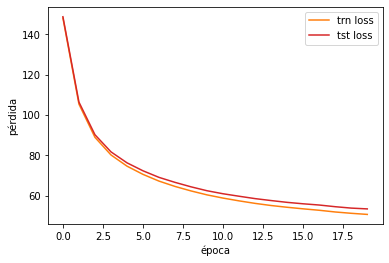

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

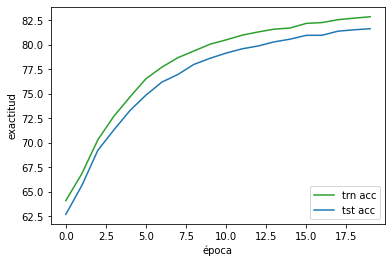

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## 5 Evaluación

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/eval_trn_tst.svg" width="470"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

### 5.1 Evaluación final

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 50.63, 53.35] acc=[82.87,81.65]


### 5.2 Inferencia

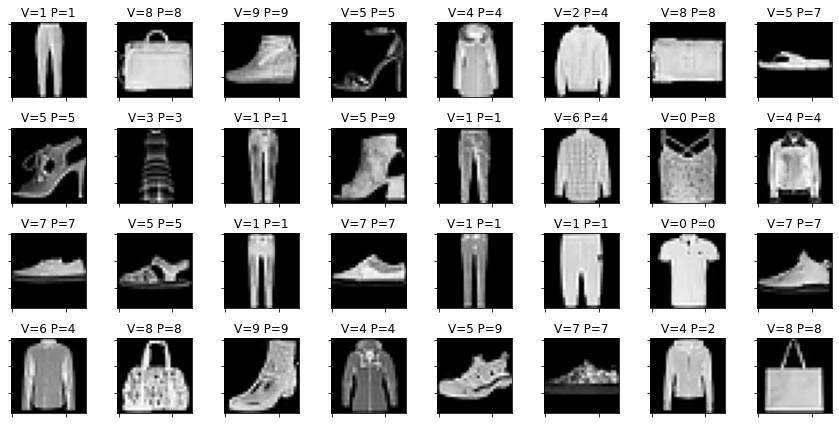

In [ ]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

### Prueba con distintas configuraciones
#### Disminuir la tasa de aprendizaje
Tasa de aprendizaje $\alpha = 0.0001$, $20$ épocas, $1$ capa oculta de $128$ neuronas, función de activación ReLU.

In [ ]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-4, epochs=20) #RELU PROBLEM

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[220.02,220.00] acc=[31.84,31.82]
E01 loss=[211.38,211.39] acc=[36.74,36.75]
E02 loss=[202.68,202.73] acc=[39.87,39.88]
E03 loss=[193.74,193.88] acc=[46.80,46.46]
E04 loss=[184.64,184.80] acc=[53.29,52.81]
E05 loss=[175.63,175.87] acc=[57.90,57.24]
E06 loss=[166.97,167.26] acc=[60.28,59.62]
E07 loss=[158.88,159.20] acc=[61.61,60.83]
E08 loss=[151.43,151.82] acc=[62.65,61.68]
E09 loss=[144.63,145.07] acc=[63.33,62.27]
E10 loss=[138.48,138.95] acc=[64.05,63.00]
E11 loss=[132.95,133.47] acc=[64.77,63.64]
E12 loss=[127.99,128.62] acc=[65.28,64.45]
E13 loss=[123.54,124.20] acc=[65.55,64.73]
E14 loss=[119.54,120.23] acc=[65.98,64.99]
E15 loss=[115.94,116.66] acc=[66.17,65.26]
E16 loss=[112.70,113.47] acc=[66.32,65.34]
E17 loss=[109.76,110.57] acc=[66.59,65.55]
E18 loss=[107.10,107.97] acc=[66.77,65.63]
E19 loss=[104.68,105.59] acc=[67.06,65.66]


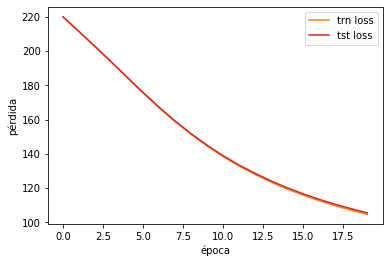

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

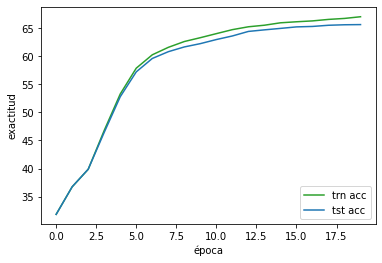

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[104.68,105.62] acc=[67.06,65.65]


**Conclusión:** Disminuir la tasa de aprendizaje provocó que el modelo aprendiera mucho más lento, por lo que se requiere un mayor número de épocas para entrenar y no es lo que se desea.

#### Aumentar la tasa de aprendizaje
Tasa de aprendizaje $\alpha = 0.1$, $20$ épocas, $1$ capa oculta de $128$ neuronas, función de activación ReLU.

In [ ]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-1, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 43.56, 47.33] acc=[83.93,82.56]
E01 loss=[ 36.88, 40.67] acc=[86.76,85.40]
E02 loss=[ 34.55, 40.16] acc=[87.50,85.63]
E03 loss=[ 32.57, 38.61] acc=[87.80,85.77]
E04 loss=[ 30.59, 37.46] acc=[88.62,86.33]
E05 loss=[ 30.51, 37.52] acc=[88.76,86.55]
E06 loss=[ 28.57, 36.01] acc=[89.52,87.27]
E07 loss=[ 27.15, 34.60] acc=[90.01,87.15]
E08 loss=[ 26.43, 34.87] acc=[90.13,87.24]
E09 loss=[ 24.73, 33.06] acc=[90.81,88.09]
E10 loss=[ 23.28, 32.67] acc=[91.27,88.05]
E11 loss=[ 24.26, 34.36] acc=[91.06,87.68]
E12 loss=[ 23.55, 33.63] acc=[91.42,88.03]
E13 loss=[ 22.05, 32.52] acc=[91.88,88.59]
E14 loss=[ 21.80, 33.27] acc=[91.93,88.50]
E15 loss=[ 21.36, 33.08] acc=[92.12,88.48]
E16 loss=[ 22.12, 34.56] acc=[91.60,87.88]
E17 loss=[ 22.63, 34.83] acc=[91.51,87.67]
E18 loss=[ 19.04, 32.01] acc=[92.99,88.73]
E19 loss=[ 19.34, 33.09] acc=[92.88,88.63]


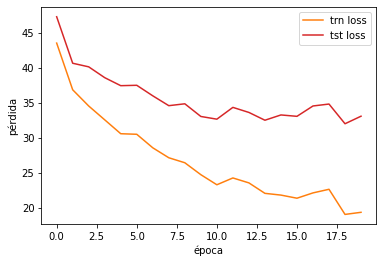

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

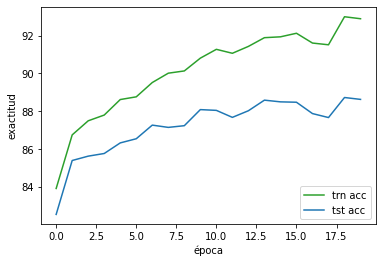

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 19.34, 33.01] acc=[92.88,88.65]


**Conclusión:** Aumentar la tasa de aprendizaje provocó que el modelo aprendiera mucho más rápido, en este caso fue un valor diez veces mayor y a pesar de eso no se ven señales de divergencia.

#### Incrementar a 512 el número de neuronas de la capa oculta y mantener tasa de aprendizaje a 0.1.
Tasa de aprendizaje $\alpha = 0.1$, $20$ épocas, $1$ capa oculta de $512$ neuronas, función de activación ReLU.


In [ ]:
# Definición del modelo
class FCN(nn.Module):

    # Inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 512, 10

        # definición de capas
        self.cls = nn.Sequential(
            # Se aplana la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 512]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            # fc2
            # [N, 512] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

print(FCN())

FCN(
  (cls): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-1, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 38.92, 42.75] acc=[86.20,84.82]
E01 loss=[ 36.17, 40.60] acc=[86.88,85.31]
E02 loss=[ 32.89, 38.33] acc=[87.88,86.13]
E03 loss=[ 32.06, 37.71] acc=[88.42,86.44]
E04 loss=[ 32.04, 38.34] acc=[88.01,85.92]
E05 loss=[ 26.57, 33.58] acc=[90.16,88.05]
E06 loss=[ 26.32, 34.16] acc=[90.39,87.73]
E07 loss=[ 26.36, 34.42] acc=[90.29,87.79]
E08 loss=[ 25.64, 34.03] acc=[90.58,87.71]
E09 loss=[ 25.61, 35.10] acc=[90.53,87.76]
E10 loss=[ 23.39, 32.56] acc=[91.30,88.09]
E11 loss=[ 21.07, 31.29] acc=[92.22,88.93]
E12 loss=[ 20.55, 31.58] acc=[92.47,89.04]
E13 loss=[ 20.34, 32.12] acc=[92.44,89.01]
E14 loss=[ 20.85, 33.21] acc=[92.09,88.45]
E15 loss=[ 19.35, 32.12] acc=[92.89,88.89]
E16 loss=[ 19.16, 32.03] acc=[92.89,89.03]
E17 loss=[ 18.83, 32.26] acc=[93.05,88.90]
E18 loss=[ 18.74, 33.09] acc=[93.02,88.94]
E19 loss=[ 20.51, 36.27] acc=[92.47,87.97]


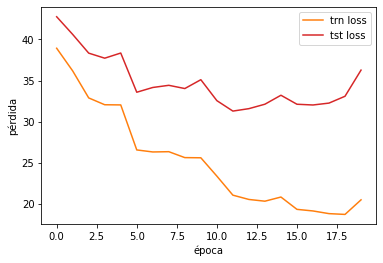

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

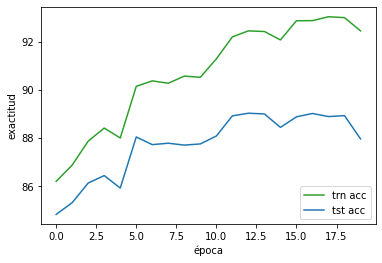

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 20.51, 36.22] acc=[92.47,87.98]


**Conclusión:** Comparado con el experimento anterior, que se diferencia por el número de neuronas de la capa oculta, los resultados son muy similares, sin embargo, la exactitud de entrenamiento disminuye ligeramente. Esto se podría deber a que hay indicios de que el modelo se está sobreajustando, ya que la pérdida del conjunto de prueba comienza a crecer alrededor de la época 16.

#### Tres capas ocultas cada una de 128 neuronas y mantener tasa de aprendizaje a 0.1.
Tasa de aprendizaje $\alpha = 0.1$, $20$ épocas, $3$ capa oculta de $128$ neuronas, función de activación ReLU.

In [ ]:
# Definición del modelo
class FCN(nn.Module):

    # Inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2, FC3, FC4 = 128, 128, 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # Se aplana la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            nn.Linear(FC2, FC3),
            nn.ReLU(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC3, FC4)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

print(FCN())

FCN(
  (cls): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-1, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 42.70, 46.12] acc=[84.06,82.92]
E01 loss=[ 38.15, 42.80] acc=[86.24,84.64]
E02 loss=[ 32.61, 37.63] acc=[87.86,86.04]
E03 loss=[ 31.84, 37.36] acc=[87.99,86.01]
E04 loss=[ 30.46, 36.88] acc=[88.76,86.66]
E05 loss=[ 33.97, 41.19] acc=[87.29,84.80]
E06 loss=[ 27.74, 35.94] acc=[89.72,87.38]
E07 loss=[ 30.70, 39.19] acc=[88.52,86.38]
E08 loss=[ 25.65, 33.93] acc=[90.44,87.76]
E09 loss=[ 25.13, 34.05] acc=[90.34,87.53]
E10 loss=[ 23.49, 33.86] acc=[91.10,88.00]
E11 loss=[ 22.87, 32.83] acc=[91.44,88.50]
E12 loss=[ 24.10, 35.36] acc=[90.84,87.38]
E13 loss=[ 20.63, 32.32] acc=[92.21,88.86]
E14 loss=[ 23.36, 34.39] acc=[91.10,87.92]
E15 loss=[ 20.32, 33.83] acc=[92.34,88.81]
E16 loss=[ 19.80, 32.05] acc=[92.65,89.24]
E17 loss=[ 19.08, 31.99] acc=[92.74,89.11]
E18 loss=[ 20.27, 33.80] acc=[91.77,88.19]
E19 loss=[ 27.94, 45.74] acc=[90.40,86.42]


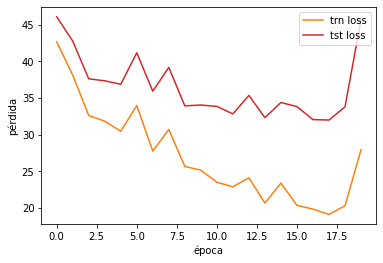

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

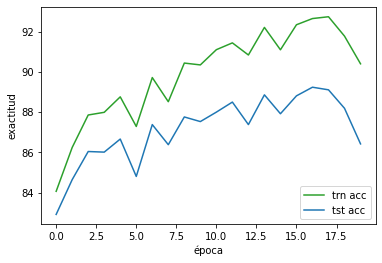

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 27.94, 45.72] acc=[90.40,86.44]


**Conclusión:** Aumentar el número de capas ocultas incrementó de manera significativa el número de parámetros, por lo que es más probable que exista sobreajuste. En este caso, es notorio como comienza a subir la pérdida mucho más rápido y hay ligeros indicios de divergencia.

### Utilizar una función de activación sigmoide y mantener tasa de aprendizaje a 0.1.
Tasa de aprendizaje $\alpha = 0.1$, $20$ épocas, $1$ capa oculta de $128$ neuronas, función de activación Sigmoide.

In [ ]:
# Definición del modelo
class FCN(nn.Module):

    # Inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # Se aplana la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

In [ ]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-1, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 53.22, 55.73] acc=[80.72,79.49]
E01 loss=[ 44.61, 47.83] acc=[84.13,82.45]
E02 loss=[ 41.20, 44.88] acc=[85.21,83.75]
E03 loss=[ 39.56, 43.49] acc=[85.86,84.49]
E04 loss=[ 37.96, 42.26] acc=[86.41,84.48]
E05 loss=[ 36.39, 41.07] acc=[87.12,85.42]
E06 loss=[ 35.35, 39.98] acc=[87.21,85.63]
E07 loss=[ 35.06, 40.17] acc=[87.42,85.67]
E08 loss=[ 34.05, 39.00] acc=[87.62,85.74]
E09 loss=[ 33.65, 39.03] acc=[87.96,85.99]
E10 loss=[ 32.47, 37.89] acc=[88.28,86.66]
E11 loss=[ 31.71, 37.26] acc=[88.58,86.56]
E12 loss=[ 31.51, 37.35] acc=[88.75,86.64]
E13 loss=[ 30.92, 37.27] acc=[88.90,86.73]
E14 loss=[ 30.55, 36.91] acc=[88.99,86.68]
E15 loss=[ 30.36, 36.94] acc=[88.88,86.66]
E16 loss=[ 29.73, 36.68] acc=[89.28,86.82]
E17 loss=[ 28.86, 35.93] acc=[89.64,87.31]
E18 loss=[ 28.70, 35.56] acc=[89.52,87.23]
E19 loss=[ 28.02, 35.54] acc=[89.91,87.51]


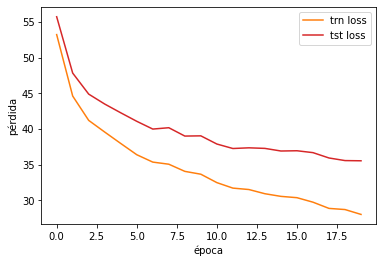

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

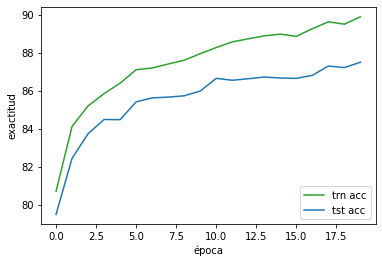

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 28.02, 35.54] acc=[89.91,87.51]


**Conclusión:** Utilizar una función de activación saturada como la sigmoide claramente disminuyó la exactitud tanto de entrenamiento como de prueba, debido a que los gradientes se comienzan a desvanecer cuando se propagan hacia atrás.

### Función de activación tanh y mantener tasa de aprendizaje a 0.1.
Tasa de aprendizaje $\alpha = 0.1$, $20$ épocas, $1$ capa oculta de $128$ neuronas, función de activación Tanh.

In [ ]:
# Definición del modelo
class FCN(nn.Module):

    # Inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # Se aplana la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.Tanh(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

In [ ]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-1, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 43.62, 47.07] acc=[84.05,82.78]
E01 loss=[ 37.76, 42.22] acc=[86.35,85.00]
E02 loss=[ 34.02, 38.87] acc=[87.80,86.16]
E03 loss=[ 32.20, 37.75] acc=[88.47,86.50]
E04 loss=[ 36.55, 42.75] acc=[86.22,84.45]
E05 loss=[ 30.29, 36.94] acc=[88.98,86.52]
E06 loss=[ 32.22, 39.24] acc=[88.15,86.39]
E07 loss=[ 28.20, 35.91] acc=[89.56,86.93]
E08 loss=[ 26.91, 34.94] acc=[90.16,87.45]
E09 loss=[ 25.79, 33.87] acc=[90.38,87.65]
E10 loss=[ 25.29, 34.63] acc=[90.71,87.51]
E11 loss=[ 28.57, 38.19] acc=[88.95,85.43]
E12 loss=[ 24.79, 34.58] acc=[90.80,87.47]
E13 loss=[ 22.79, 33.31] acc=[91.59,88.13]
E14 loss=[ 24.02, 34.97] acc=[91.11,87.52]
E15 loss=[ 23.61, 34.89] acc=[91.18,87.60]
E16 loss=[ 23.95, 35.62] acc=[90.99,87.30]
E17 loss=[ 22.15, 34.57] acc=[91.57,87.68]
E18 loss=[ 19.98, 32.43] acc=[92.70,88.64]
E19 loss=[ 22.94, 36.08] acc=[91.24,87.36]


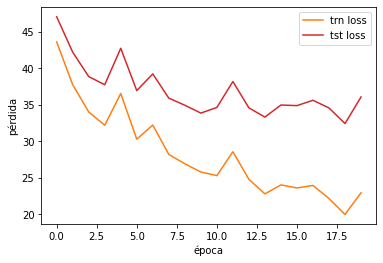

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

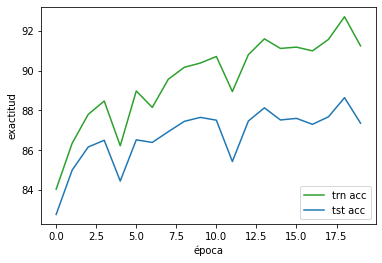

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 22.94, 36.12] acc=[91.24,87.34]


**Conclusión:**La tangente hiperbólica es otra función saturada que al establecerse como función de activación de las neuronas actúa de manera similar a la sigmoide, ya que la exactitud de prueba es casi la misma. Sin embargo, aquí se obtuvo una exactitud de entrenamiento mucho mayor. La solución a esto como se mostró en el modelo base es utilizar una función ReLU.

### Conclusiones generales de los experimentos

Con respecto a las funciones de activación, emplear funciones saturadas puede resultar perjudicial, si por ejemplo los valores de la entrada son muy grandes o muy pequeños, al momento de la retropropagación los gradientes podrían llegar a valer cero, lo que provoca que no se actualicen los pesos y sesgos en esas capas de manera correcta.  
A pesar de que una solución puede ser emplear la función ReLU, que en este caso resultó exitoso, hay que considerar que no es infalible, esta función es sensible a tasas de aprendizaje grandes.  
Ese problema se debe a que la función ReLU podría retornar un valor constante para valores negativos y si la tasa de aprendizaje es muy grande ($\alpha$): $W_j^{t} = W_j^{t-1} - \alpha \sum{i=1}^n(\hat{y}^{(i)} - y^{(i)}) * x_j^{(i)}$ en la fórmula anterior si $W_j$ es menor que el lado derecho de la resta, debido al $\alpha$, podría actualizarse los pesos con valores negativos y la función de activación retornaría un valor constante sin importar el valor del peso negativo.  
  
Con respecto al número de neuronas se debe encontrar un valor aceptable para el conjunto de datos, en este caso, se mostró que un valor muy grande puede causar sobreajuste en el modelo (pierde generalidad), ya que el número de parámetros crece. Además, requiere de un mayor tiempo de entrenamiento.  

Por otro lado, un número de mayor de capas puede ser beneficioso si el número de entradas de la red es grande, ya que la forma de modelar los datos es más compleja. Sin embargo, se incrementa la complejidad de la red y hay posibilidad de causar sobreajuste. En este caso el modelo con tres capas ocultas de 128 neuronas causó sobreajuste.

Finalmente, en cuanto a los hiperparámetros, se modificó la tasa de aprendizaje. Al aumentarla, en este caso, se logró que el modelo aprendiera más rápido por cada época. Sin embargo, una tasa muy grande puede causar divergencia. Por otro lado, al disminuirla, el modelo aprendía mucho más lento y esto requería más épocas de entrenamiento lo cual no es deseable.